<a href="https://colab.research.google.com/github/royleekiat/Employee_attrition_predictor/blob/main/Employee_attrition_predictor_Roy_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Organizations often seek to discover the secrets of keeping their best talents at the firm. However, this is not as straightforward as it seems.

The goal of this project is to allow Deep learning to discover the chance of employee attrition based on a dataset of employee data.

# Dataset

Taken from Kaggle [Employee Attrition](https://www.kaggle.com/colearninglounge/employee-attrition)

#Models

The **First Model** is based on [Red Dragon AI](http://reddragonai.com/)'s class [example](https://colab.research.google.com/drive/1ZxQCuf6Y6zKK9MhTQVnHRI-epfRsUgoP?usp=sharing)

*   [Structured data classification from scratch](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/) by [fchollet](https://twitter.com/fchollet)

Steps


1.   Read files
2.   Drop columns
3.   Preprocess data
4.   Normalize integers, convert strings, do one hot encoding
5.   concat input, Build model
6.   View model
7.   Add checkpoints, save history, train, plot history
8.   Predict on sample data
9.   Predict on 400+ employees and chart prediction outcome


After the first model, I tried to look for an alternative way to handle the input before training, and that brings us to the second model

The **Second Model** seeks to use Tensorflow's feature columns to manage the columns based on 


1.   Numerical columns
2.   Categorical columns
3.   Embedding columns
4.   Crossed feature columns

Then, we will compare and arrive at a conclusion by comparing the model accuracy.





#Install & import

Install Tensorflow 2.3 or tf-nightly

In [1]:
%pip -q install tf-nightly

     |████████████████████████████████| 391.9MB 44kB/s 
     |████████████████████████████████| 10.6MB 2.6MB/s 
     |████████████████████████████████| 471kB 45.7MB/s 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import tensorflow as tf
import numpy as np
from numpy import unique
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, TensorBoard


In [3]:
tf.__version__

'2.4.0-dev20201004'

# Read files

I downloaded the files from Kaggle and hosted the files on my Google drive as csv. Alternatively you can fetch using Kaggle's API.

In [4]:
#Training and validation dataset
file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRTzmPbXWcC6mfBDE1MBg5HoHsYlvYtkZp8oJFHfIMNzqiG6P4cdGaceWsxW9JS6ip9vdJYCNrDEbOx/pub?gid=581336355&single=true&output=csv"
dataframe = pd.read_csv(file_url)
dataframe.shape




(1029, 37)

In [5]:
#Prediction dataset
pred_file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRsxR0nTrEaCqfro4FvGNDn6ZYYdQS0e2Tev1SMtJ5jYIjU0WGp77hp6btdJYkMl3XAk4lA01hxE30o/pub?gid=2057317048&single=true&output=csv"
pred_dataframe = pd.read_csv(pred_file_url)
pred_dataframe.shape

(441, 34)

In [6]:
dataframe.head(n=10)

,id,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionBinary
0,1,50,No,Travel_Rarely,1126,Research & Development,1,2,Medical,1,997,4,Male,66,3,4,Research Director,4,Divorced,17399,6615,9,Y,No,22,4,3,80,1,32,1,2,5,4,1,3,0
1,2,36,No,Travel_Rarely,216,Research & Development,6,2,Medical,1,178,2,Male,84,3,2,Manufacturing Director,2,Divorced,4941,2819,6,Y,No,20,4,4,80,2,7,0,3,3,2,0,1,0
2,3,21,Yes,Travel_Rarely,337,Sales,7,1,Marketing,1,1780,2,Male,31,3,1,Sales Representative,2,Single,2679,4567,1,Y,No,13,3,2,80,0,1,3,3,1,0,1,0,1
3,4,50,No,Travel_Frequently,1246,Human Resources,6,3,Medical,1,644,1,Male,99,3,5,Manager,2,Married,18200,7999,1,Y,No,11,3,3,80,1,32,2,3,32,5,10,7,0
4,5,52,No,Travel_Rarely,994,Research & Development,7,4,Life Sciences,1,1118,2,Male,87,3,3,Healthcare Representative,2,Single,10445,15322,7,Y,No,19,3,4,80,0,18,4,3,8,6,4,0,0
5,6,33,Yes,Travel_Rarely,1277,Research & Development,15,1,Medical,1,582,2,Male,56,3,3,Manager,3,Married,13610,24619,7,Y,Yes,12,3,4,80,0,15,2,4,7,6,7,7,1
6,7,47,No,Travel_Rarely,1001,Research & Development,4,3,Life Sciences,1,1827,3,Female,92,2,3,Manufacturing Director,2,Divorced,10333,19271,8,Y,Yes,12,3,3,80,1,28,4,3,22,11,14,10,0
7,8,22,No,Travel_Rarely,1230,Research & Development,1,2,Life Sciences,1,872,4,Male,33,2,2,Manufacturing Director,4,Married,4775,19146,6,Y,No,22,4,1,80,2,4,2,1,2,2,2,2,0
8,9,26,Yes,Travel_Rarely,890,Research & Development,2,4,Medical,1,828,3,Male,46,3,1,Research Scientist,3,Single,4382,16374,6,Y,No,17,3,4,80,0,5,3,2,2,2,2,1,1
9,10,33,No,Non-Travel,530,Sales,16,3,Life Sciences,1,1681,3,Female,36,3,2,Sales Executive,4,Divorced,5368,16130,1,Y,Yes,25,4,3,80,1,7,2,3,6,5,1,2,0


I added a column "AttritionBinary" beside to the dataset to make it easier to process the data :) . No = 0, 1 = Yes. 

The data has 1029 rows and 36 columns.

In [7]:
pred_dataframe.head(n=10)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,1,1469,4,Male,84,3,2,Sales Executive,1,Single,8463,23490,0,Y,No,18,3,4,80,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,1,250,4,Female,57,4,2,Manufacturing Director,1,Divorced,4450,26250,1,Y,No,11,3,3,80,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,1,1714,4,Male,58,1,1,Human Resources,3,Married,1555,11585,1,Y,No,11,3,3,80,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,1,86,2,Male,59,3,3,Research Scientist,1,Divorced,9724,18787,2,Y,No,17,3,3,80,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,1,304,4,Male,62,3,2,Laboratory Technician,2,Single,5914,9945,8,Y,No,16,3,4,80,0,16,3,4,13,11,3,7
5,34.0,Travel_Rarely,204.0,Sales,14.0,3,Technical Degree,1,666,3,Female,31,3,1,Sales Representative,3,Divorced,2579,2912,1,Y,Yes,18,3,4,80,2,8,3,3,8,2,0,6
6,NaN,Travel_Rarely,144.0,Research & Development,22.0,3,Life Sciences,1,577,4,Male,46,1,1,Laboratory Technician,3,Single,4230,19225,0,Y,No,15,3,3,80,0,6,2,3,5,4,4,3
7,39.0,Travel_Rarely,1431.0,Research & Development,1.0,4,Medical,1,332,3,Female,96,3,1,Laboratory Technician,3,,2232,15417,7,Y,No,14,3,3,80,3,7,1,3,3,2,1,2
8,45.0,Non-Travel,1052.0,Sales,6.0,3,Medical,1,302,4,Female,57,2,3,Sales Executive,4,Single,8865,16840,6,Y,No,12,3,4,80,0,23,2,3,19,7,12,8
9,NaN,Travel_Rarely,1229.0,Research & Development,8.0,1,Life Sciences,1,63,4,Male,36,4,1,Laboratory Technician,4,Married,2269,4892,1,Y,No,19,3,4,80,0,1,2,3,1,0,0,1


# Drop columns that I do not intend to use as features 

Dropping these useless columns
- id	
- Attrition	
- EmployeeCount	
- EmployeeNumber

In [8]:
dataframe = dataframe.drop(['id','Attrition','EmployeeCount','EmployeeNumber'], axis=1)

dataframe.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionBinary
0,50,Travel_Rarely,1126,Research & Development,1,2,Medical,4,Male,66,3,4,Research Director,4,Divorced,17399,6615,9,Y,No,22,4,3,80,1,32,1,2,5,4,1,3,0
1,36,Travel_Rarely,216,Research & Development,6,2,Medical,2,Male,84,3,2,Manufacturing Director,2,Divorced,4941,2819,6,Y,No,20,4,4,80,2,7,0,3,3,2,0,1,0
2,21,Travel_Rarely,337,Sales,7,1,Marketing,2,Male,31,3,1,Sales Representative,2,Single,2679,4567,1,Y,No,13,3,2,80,0,1,3,3,1,0,1,0,1
3,50,Travel_Frequently,1246,Human Resources,6,3,Medical,1,Male,99,3,5,Manager,2,Married,18200,7999,1,Y,No,11,3,3,80,1,32,2,3,32,5,10,7,0
4,52,Travel_Rarely,994,Research & Development,7,4,Life Sciences,2,Male,87,3,3,Healthcare Representative,2,Single,10445,15322,7,Y,No,19,3,4,80,0,18,4,3,8,6,4,0,0


# Splitting dataset into Training and Validation 

- Training: 80% 
- Validation: 20%

In [9]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)


print(
    "Using %d samples for training, %d for validation and %d for predicting"
    % (len(train_dataframe), len(val_dataframe), len(pred_dataframe))
)

Using 823 samples for training, 206 for validation and 441 for predicting


In [10]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("AttritionBinary")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def pred_dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds



train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
pred_ds = pred_dataframe_to_dataset(pred_dataframe)

In [11]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Age': <tf.Tensor: shape=(), dtype=int64, numpy=36>, 'BusinessTravel': <tf.Tensor: shape=(), dtype=string, numpy=b'Travel_Frequently'>, 'DailyRate': <tf.Tensor: shape=(), dtype=int64, numpy=1467>, 'Department': <tf.Tensor: shape=(), dtype=string, numpy=b'Sales'>, 'DistanceFromHome': <tf.Tensor: shape=(), dtype=int64, numpy=11>, 'Education': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'EducationField': <tf.Tensor: shape=(), dtype=string, numpy=b'Technical Degree'>, 'EnvironmentSatisfaction': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'Gender': <tf.Tensor: shape=(), dtype=string, numpy=b'Female'>, 'HourlyRate': <tf.Tensor: shape=(), dtype=int64, numpy=92>, 'JobInvolvement': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'JobLevel': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'JobRole': <tf.Tensor: shape=(), dtype=string, numpy=b'Sales Executive'>, 'JobSatisfaction': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'MaritalStatus': <tf.Tensor: shape=(), dtype=string, numpy=b'Married

In [12]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

Feature preprocessing with Keras layers
The following features are categorical features encoded as integers:

- Education	
- EnvironmentSatisfaction	
- JobInvolvement	
- JobLevel	
- JobSatisfaction	
- PerformanceRating	
- RelationshipSatisfaction	
- StandardHours	
- StockOptionLevel	
- WorkLifeBalance	


We will encode these features using one-hot encoding using the CategoryEncoding() layer.

We also have some categorical features encoded as strings: 

- BusinessTravel	
- Department	
- EducationField	
- Gender	
- JobRole	
- MaritalStatus	
- Over18	
- OverTime

We will first create an index of all possible features using the StringLookup() layer, then we will one-hot encode the output indices using a CategoryEncoding() layer.

Finally, the following feature are continuous numerical features:

- Age	
- DailyRate
- DistanceFromHome	
- HourlyRate	
- MonthlyIncome	
- MonthlyRate	
- NumCompaniesWorked	
- PercentSalaryHike	
- TotalWorkingYears	
- TrainingTimesLastYear	
- YearsAtCompany	
- YearsInCurrentRole	
- YearsSinceLastPromotion	
- YearsWithCurrManager	


For each of these features, we will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

Below, we use 3 utility functions to do the operations (all 3 functions were written by fchollet):

* encode_numerical_feature to apply featurewise normalization to numerical features.
* encode_string_categorical_feature to first turn string inputs into integer indices, then one-hot encode these integer indices.
* encode_integer_categorical_feature to one-hot encode integer categorical features.

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature





# Build Model

The different learning rate, activation function, dropout and number of layers were added so as to improve overall training accuracy.

In [14]:
# Categorical features encoded as integers

Education = keras.Input(shape=(1,), name="Education", dtype="int64")
EnvironmentSatisfaction = keras.Input(shape=(1,), name="EnvironmentSatisfaction", dtype="int64")
JobInvolvement = keras.Input(shape=(1,), name="JobInvolvement", dtype="int64")
JobLevel = keras.Input(shape=(1,), name="JobLevel", dtype="int64")
JobSatisfaction = keras.Input(shape=(1,), name="JobSatisfaction", dtype="int64")
PerformanceRating = keras.Input(shape=(1,), name="PerformanceRating", dtype="int64")
RelationshipSatisfaction = keras.Input(shape=(1,), name="RelationshipSatisfaction", dtype="int64")
StandardHours = keras.Input(shape=(1,), name="StandardHours", dtype="int64")
StockOptionLevel = keras.Input(shape=(1,), name="StockOptionLevel", dtype="int64")
WorkLifeBalance = keras.Input(shape=(1,), name="WorkLifeBalance", dtype="int64")

# Categorical feature encoded as string

BusinessTravel = keras.Input(shape=(1,), name="BusinessTravel", dtype="string")
Department = keras.Input(shape=(1,), name="Department", dtype="string")
EducationField = keras.Input(shape=(1,), name="EducationField", dtype="string")
Gender = keras.Input(shape=(1,), name="Gender", dtype="string")
JobRole = keras.Input(shape=(1,), name="JobRole", dtype="string")
MaritalStatus = keras.Input(shape=(1,), name="MaritalStatus", dtype="string")
Over18 = keras.Input(shape=(1,), name="Over18", dtype="string")
OverTime = keras.Input(shape=(1,), name="OverTime", dtype="string")

# Numerical features

Age = keras.Input(shape=(1,), name="Age")
DailyRate = keras.Input(shape=(1,), name="DailyRate")
DistanceFromHome = keras.Input(shape=(1,), name="DistanceFromHome")
HourlyRate = keras.Input(shape=(1,), name="HourlyRate")
MonthlyIncome = keras.Input(shape=(1,), name="MonthlyIncome")
MonthlyRate = keras.Input(shape=(1,), name="MonthlyRate")
NumCompaniesWorked = keras.Input(shape=(1,), name="NumCompaniesWorked")
PercentSalaryHike = keras.Input(shape=(1,), name="PercentSalaryHike")
TotalWorkingYears = keras.Input(shape=(1,), name="TotalWorkingYears")
TrainingTimesLastYear = keras.Input(shape=(1,), name="TrainingTimesLastYear")
YearsAtCompany = keras.Input(shape=(1,), name="YearsAtCompany")
YearsInCurrentRole = keras.Input(shape=(1,), name="YearsInCurrentRole")
YearsSinceLastPromotion = keras.Input(shape=(1,), name="YearsSinceLastPromotion")
YearsWithCurrManager = keras.Input(shape=(1,), name="YearsWithCurrManager")

all_inputs = [
    Education,
    EnvironmentSatisfaction,
    JobInvolvement,
    JobLevel,
    JobSatisfaction,
    PerformanceRating,
    RelationshipSatisfaction,
    StandardHours,
    StockOptionLevel,
    WorkLifeBalance,

    BusinessTravel,
    Department,
    EducationField,
    Gender,
    JobRole,
    MaritalStatus,
    Over18,
    OverTime,

    Age,
    DailyRate,
    DistanceFromHome,
    HourlyRate,
    MonthlyIncome,
    MonthlyRate,
    NumCompaniesWorked,
    PercentSalaryHike,
    TotalWorkingYears,
    TrainingTimesLastYear,
    YearsAtCompany,
    YearsInCurrentRole,
    YearsSinceLastPromotion,
    YearsWithCurrManager
]

# Integer categorical features
Education_encoded = encode_integer_categorical_feature(Education, "Education", train_ds)
EnvironmentSatisfaction_encoded = encode_integer_categorical_feature(EnvironmentSatisfaction, "EnvironmentSatisfaction", train_ds)
JobInvolvement_encoded = encode_integer_categorical_feature(JobInvolvement, "JobInvolvement", train_ds)
JobLevel_encoded = encode_integer_categorical_feature(JobLevel, "JobLevel", train_ds)
JobSatisfaction_encoded = encode_integer_categorical_feature(JobSatisfaction, "JobSatisfaction", train_ds)
PerformanceRating_encoded = encode_integer_categorical_feature(PerformanceRating, "PerformanceRating", train_ds)
RelationshipSatisfaction_encoded = encode_integer_categorical_feature(RelationshipSatisfaction, "RelationshipSatisfaction", train_ds)
StandardHours_encoded = encode_integer_categorical_feature(StandardHours, "StandardHours", train_ds)
StockOptionLevel_encoded = encode_integer_categorical_feature(StockOptionLevel, "StockOptionLevel", train_ds)
WorkLifeBalance_encoded = encode_integer_categorical_feature(WorkLifeBalance, "WorkLifeBalance", train_ds)

# String categorical features
BusinessTravel_encoded = encode_string_categorical_feature(BusinessTravel, "BusinessTravel", train_ds)
Department_encoded = encode_string_categorical_feature(Department, "Department", train_ds)
EducationField_encoded = encode_string_categorical_feature(EducationField, "EducationField", train_ds)
Gender_encoded = encode_string_categorical_feature(Gender, "Gender", train_ds)
JobRole_encoded = encode_string_categorical_feature(JobRole, "JobRole", train_ds)
MaritalStatus_encoded = encode_string_categorical_feature(MaritalStatus, "MaritalStatus", train_ds)
Over18_encoded = encode_string_categorical_feature(Over18, "Over18", train_ds)
OverTime_encoded = encode_string_categorical_feature(OverTime, "OverTime", train_ds)

# Numerical features
Age_encoded = encode_numerical_feature(Age, "Age", train_ds)
DailyRate_encoded = encode_numerical_feature(DailyRate, "DailyRate", train_ds)
DistanceFromHome_encoded = encode_numerical_feature(DistanceFromHome, "DistanceFromHome", train_ds)
HourlyRate_encoded = encode_numerical_feature(HourlyRate, "HourlyRate", train_ds)
MonthlyIncome_encoded = encode_numerical_feature(MonthlyIncome, "MonthlyIncome", train_ds)
MonthlyRate_encoded = encode_numerical_feature(MonthlyRate, "MonthlyRate", train_ds)
NumCompaniesWorked_encoded = encode_numerical_feature(NumCompaniesWorked, "NumCompaniesWorked", train_ds)
PercentSalaryHike_encoded = encode_numerical_feature(PercentSalaryHike, "PercentSalaryHike", train_ds)
TotalWorkingYears_encoded = encode_numerical_feature(TotalWorkingYears, "TotalWorkingYears", train_ds)
TrainingTimesLastYear_encoded = encode_numerical_feature(TrainingTimesLastYear, "TrainingTimesLastYear", train_ds)
YearsAtCompany_encoded = encode_numerical_feature(YearsAtCompany, "YearsAtCompany", train_ds)
YearsInCurrentRole_encoded = encode_numerical_feature(YearsInCurrentRole, "YearsInCurrentRole", train_ds)
YearsSinceLastPromotion_encoded = encode_numerical_feature(YearsSinceLastPromotion, "YearsSinceLastPromotion", train_ds)
YearsWithCurrManager_encoded = encode_numerical_feature(YearsWithCurrManager, "YearsWithCurrManager", train_ds)

all_features = layers.concatenate(
    [
      Education_encoded,
      EnvironmentSatisfaction_encoded,
      JobInvolvement_encoded,
      JobLevel_encoded,
      JobSatisfaction_encoded,
      PerformanceRating_encoded,
      RelationshipSatisfaction_encoded,
      StandardHours_encoded,
      StockOptionLevel_encoded,
      WorkLifeBalance_encoded,
      BusinessTravel_encoded,
      Department_encoded,
      EducationField_encoded,
      Gender_encoded,
      JobRole_encoded,
      MaritalStatus_encoded,
      Over18_encoded,
      OverTime_encoded,
      Age_encoded,
      DailyRate_encoded,
      DistanceFromHome_encoded,
      HourlyRate_encoded,
      MonthlyIncome_encoded,
      MonthlyRate_encoded,
      NumCompaniesWorked_encoded,
      PercentSalaryHike_encoded,
      TotalWorkingYears_encoded,
      TrainingTimesLastYear_encoded,
      YearsAtCompany_encoded,
      YearsInCurrentRole_encoded,
      YearsSinceLastPromotion_encoded,
      YearsWithCurrManager_encoded
    ]
)

# Multiple layers with dropout (for higher accuracy)
x = layers.Dense(187, activation="tanh", name = "Dense_1")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu", name = "Dense_2")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu", name = "Dense_3")(x)
output = layers.Dense(1, activation="sigmoid",name = "Outputlayer")(x)

model = keras.Model(all_inputs, output)

#Use Adam optimizer with custom learning rate

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(opt, "binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
BusinessTravel (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
Department (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
EducationField (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
Gender (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________________

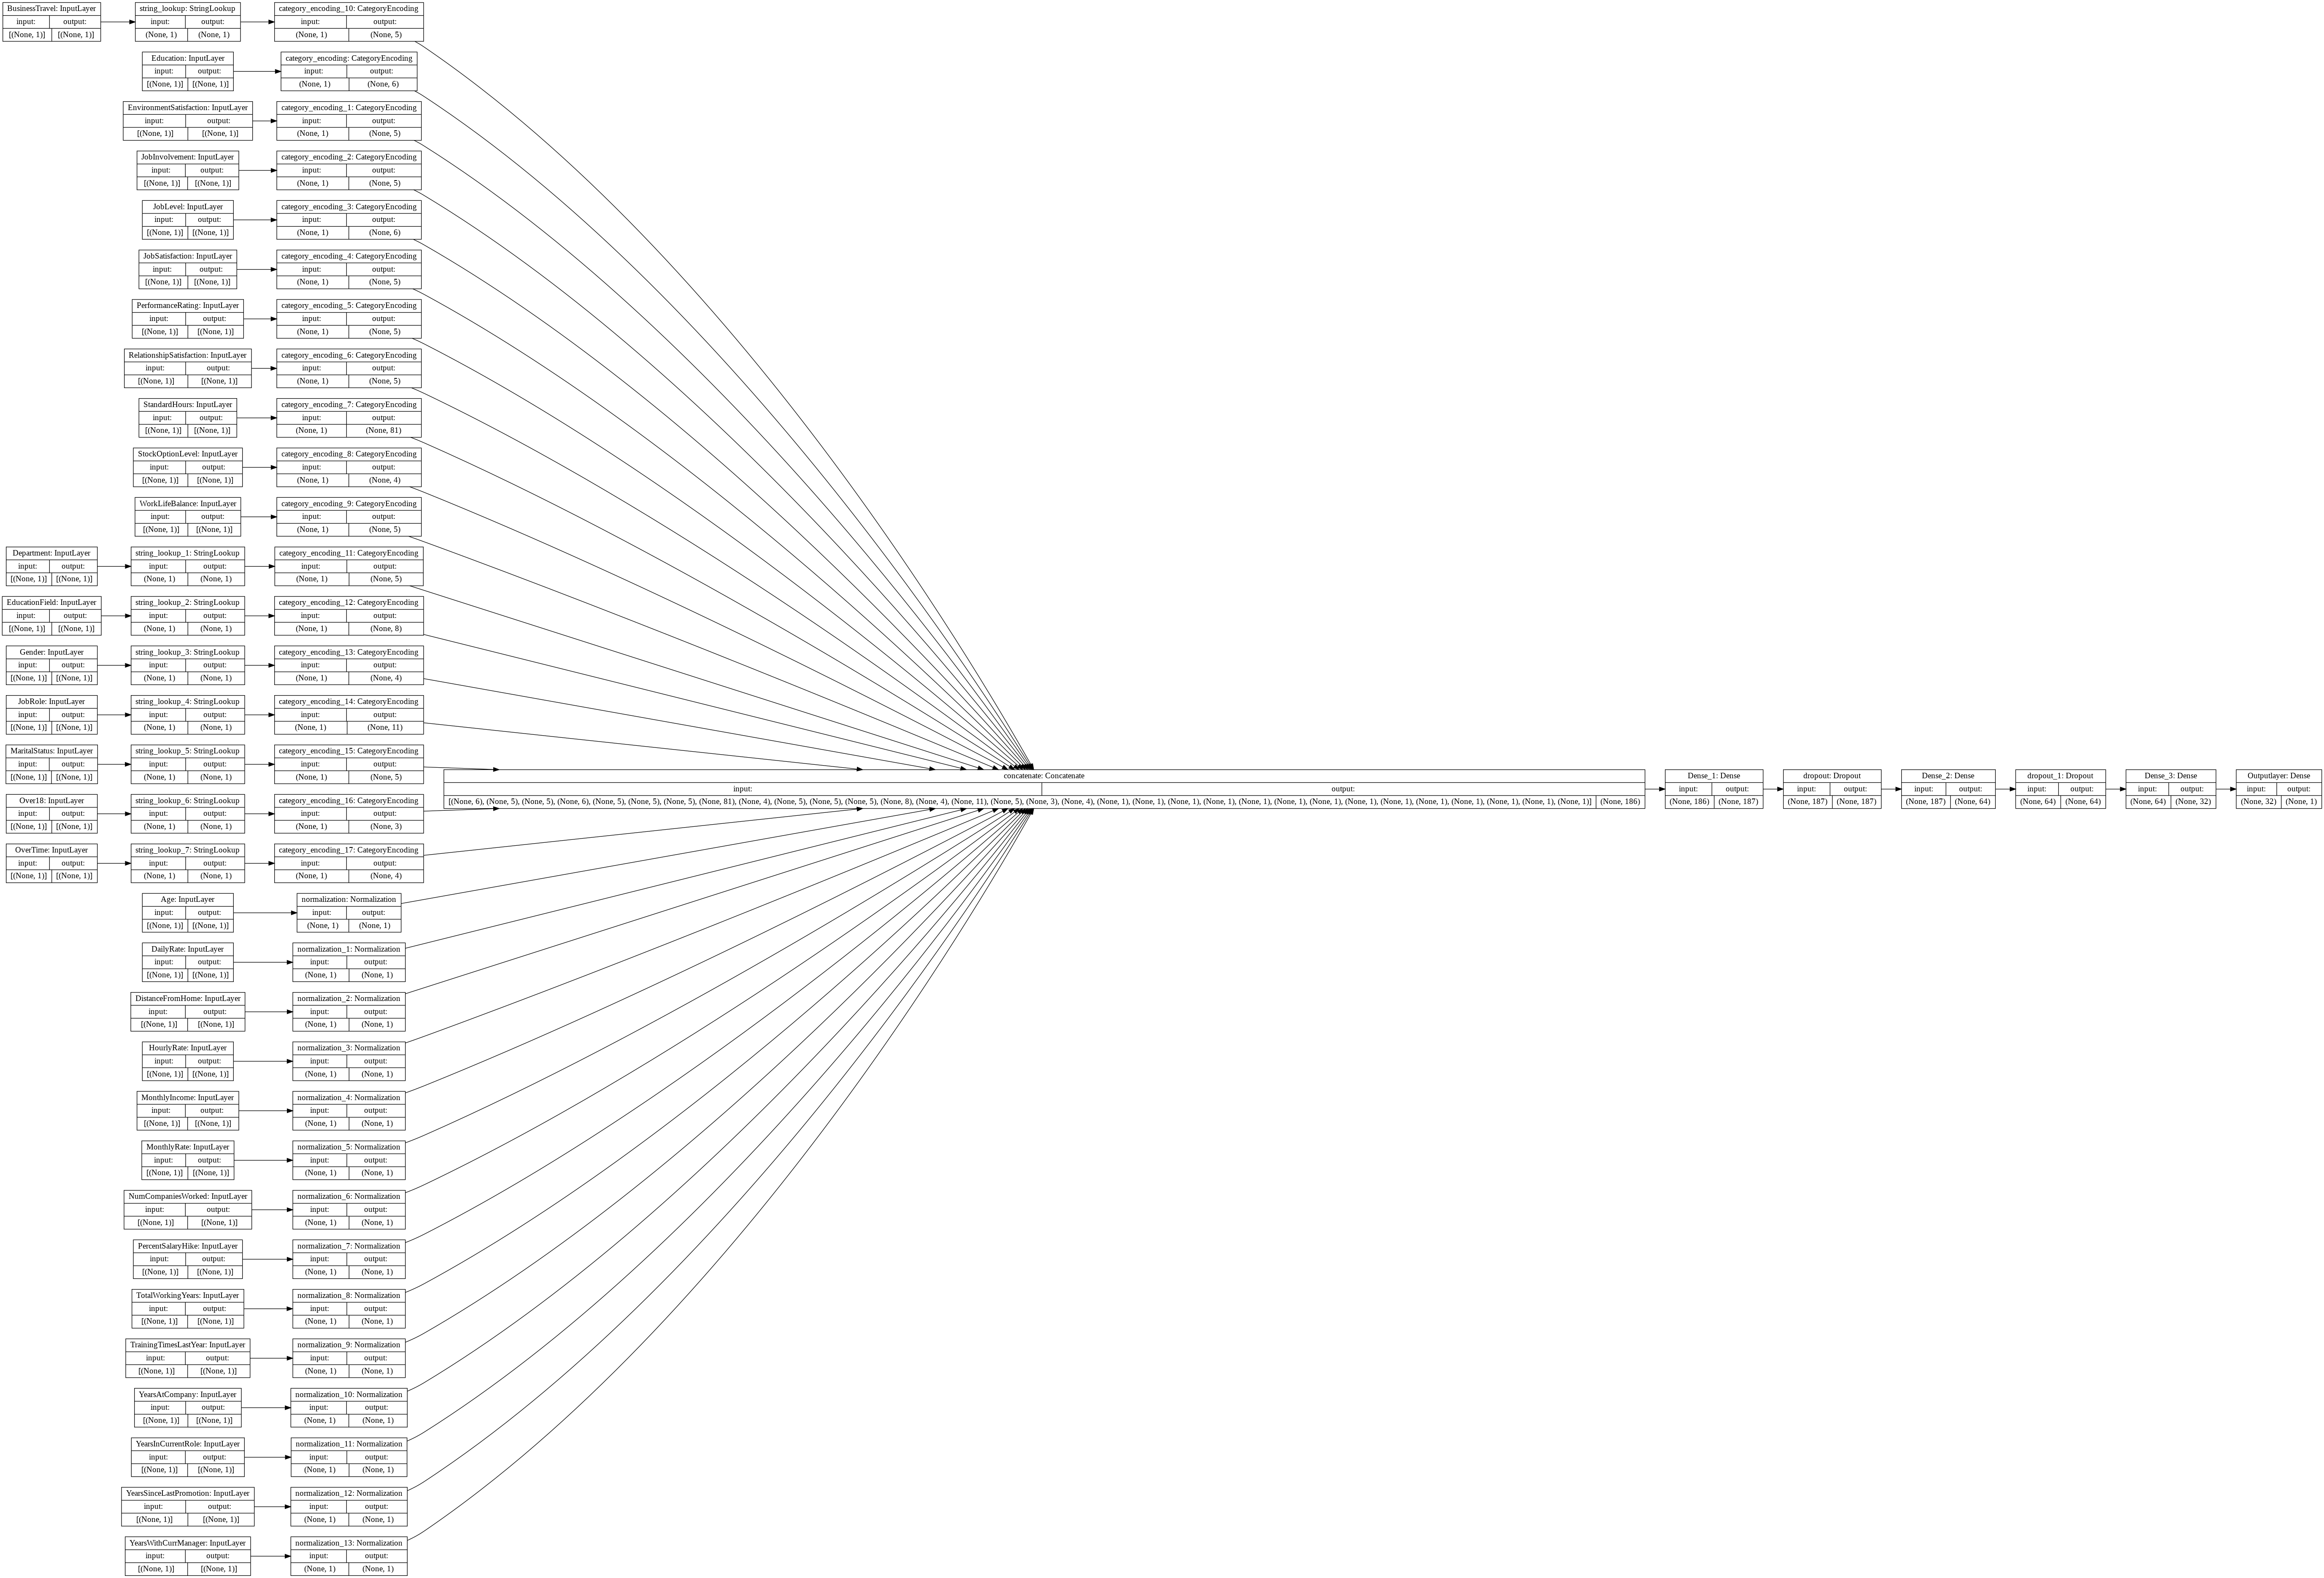

In [15]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Checkpoints

I want to use keras callbacks checkpoint to save the model at the best validation accuracy possible

In [16]:
!mkdir checkpoints
!ls

checkpoints  model.png	sample_data


In [17]:
checkpoint = ModelCheckpoint('./checkpoints/best_weights.tf', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

#Save History
Save training in "History" so that I can plot it later

In [18]:
history = model.fit(train_ds, epochs=70, validation_data=val_ds, callbacks=[checkpoint])


Epoch 1/70
18/26 [===================>..........] - ETA: 0s - loss: 0.5952 - accuracy: 0.6522 
Epoch 00001: val_accuracy improved from -inf to 0.82524, saving model to ./checkpoints/best_weights.tf


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2292: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1377: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: ./checkpoints/best_weights.tf/assets
26/26 [==============================] - 7s 239ms/step - loss: 0.5560 - accuracy: 0.6932 - val_loss: 0.4073 - val_accuracy: 0.8252
Epoch 2/70
19/26 [====================>.........] - ETA: 0s - loss: 0.4134 - accuracy: 0.8143
Epoch 00002: val_accuracy improved from 0.82524 to 0.83981, saving model to ./checkpoints/best_weights.tf
INFO:tensorflow:Assets written to: ./checkpoints/best_weights.tf/assets
26/26 [==============================] - 5s 207ms/step - loss: 0.4028 - accuracy: 0.8222 - val_loss: 0.3841 - val_accuracy: 0.8398
Epoch 3/70
20/26 [======================>.......] - ETA: 0s - loss: 0.3281 - accuracy: 0.8503
Epoch 00003: val_accuracy improved from 0.83981 to 0.86408, saving model to ./checkpoints/best_weights.tf
INFO:tensorflow:Assets written to: ./checkpoints/best_weights.tf/assets
26/26 [==============================] - 5s 212ms/step - loss: 0.3293 - accuracy: 0.8502 - val_loss: 0.3641 - val_accuracy

# Plot history

In [19]:
def plot_train(hist):
    h = hist.history
    if 'accuracy' in h:
        meas='accuracy'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

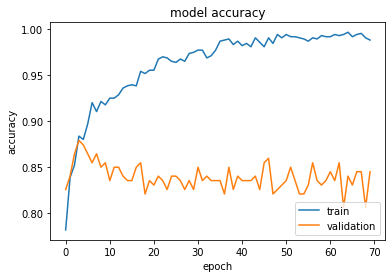

In [20]:
plot_train(history)

# Predict one sample employee data
(Taken from row 2 of test dataset [Employee Attrition test](https://www.kaggle.com/colearninglounge/employee-attrition) )



In [21]:
sample = {
    "Education": 2,
    "EnvironmentSatisfaction": 4,
    "JobInvolvement": 4,
    "JobLevel": 2,
    "JobSatisfaction": 1,
    "PerformanceRating": 3,
    "RelationshipSatisfaction": 3,
    "StandardHours": 80,
    "StockOptionLevel": 2,
    "WorkLifeBalance": 3,
    "BusinessTravel": "Travel_Rarely",
    "Department":"Research & Development",
    "EducationField":"Medical",
    "Gender":"Female",
    "JobRole":"Manufacturing Director",
    "MaritalStatus":"Divorced",
    "Over18":"Y",
    "OverTime":"No",
    "Age": 53,
    "DailyRate": 1084,
    "DistanceFromHome": 13,
    "HourlyRate": 57,
    "MonthlyIncome": 4450,
    "MonthlyRate": 26250,
    "NumCompaniesWorked": 1,
    "PercentSalaryHike": 11,
    "TotalWorkingYears": 5,
    "TrainingTimesLastYear": 3,
    "YearsAtCompany": 4,
    "YearsInCurrentRole": 2,
    "YearsSinceLastPromotion": 1,
    "YearsWithCurrManager": 3,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
model.predict(input_dict)

array([[1.748457e-10]], dtype=float32)

# Predict all employees from prediction dataset
Predict all employees from prediction dataset (441) 

In [22]:
predictions = []

for employee in pred_ds:
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in employee.items()}
    probability = model.predict(input_dict)
    employee_number = tf.get_static_value(employee["EmployeeNumber"])
    employee_age = tf.get_static_value(employee["Age"])
    employee_monthly_income = tf.get_static_value(employee["MonthlyIncome"])
    employee_satisfaction = tf.get_static_value(employee["JobSatisfaction"]) * tf.get_static_value(employee["RelationshipSatisfaction"])
    if(math.isnan(probability)):
      #Test data has missing features that cause the model to be unable to determine employee attrition %
      print(
        "We do not have a good prediction as to whether Employee Number %d will leave"
        % (employee_number)
      )
      predictions.append({
                          "Age": employee_age,
                          "MonthlyIncome":employee_monthly_income,
                          "Satisfaction":employee_satisfaction,
                          "prediction":0
                        })
    elif(probability <0.5):
      #Employee has low chance of leaving (Less than 50%)
      print(
          "Employee Number %d has a low chance of leaving (%f)"
          % (employee_number, probability)
      )
      predictions.append({
                          "Age": employee_age,
                          "MonthlyIncome":employee_monthly_income,
                          "Satisfaction":employee_satisfaction,
                          "prediction":1
                        })
    else:
      #Employee has high chance of leaving (Less than 50%)
      print(
          "Employee Number %d has a high chance of leaving (%f)"
          % (employee_number, probability)
      )
      predictions.append({
                    "Age": employee_age,
                    "MonthlyIncome":employee_monthly_income,
                    "Satisfaction":employee_satisfaction,
                    "prediction":2
                  })

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['EmployeeCount', 'EmployeeNumber'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


We do not have a good prediction as to whether Employee Number 1578 will leave
Employee Number 833 has a low chance of leaving (0.013431)
Employee Number 382 has a low chance of leaving (0.026383)
We do not have a good prediction as to whether Employee Number 1286 will leave
We do not have a good prediction as to whether Employee Number 689 will leave
Employee Number 986 has a low chance of leaving (0.000000)
Employee Number 964 has a low chance of leaving (0.005901)
Employee Number 1638 has a low chance of leaving (0.000002)
Employee Number 556 has a low chance of leaving (0.000003)
We do not have a good prediction as to whether Employee Number 1240 will leave
Employee Number 567 has a low chance of leaving (0.000022)
Employee Number 165 has a low chance of leaving (0.001527)
Employee Number 1563 has a low chance of leaving (0.175401)
Employee Number 1079 has a low chance of leaving (0.011907)
Employee Number 1950 has a low chance of leaving (0.000010)
Employee Number 903 has a low ch

#Chart Prediction Data

Display graphically using histograms

**1. By Age**

Text(0.5, 1.0, 'Employee attrition probability by age')

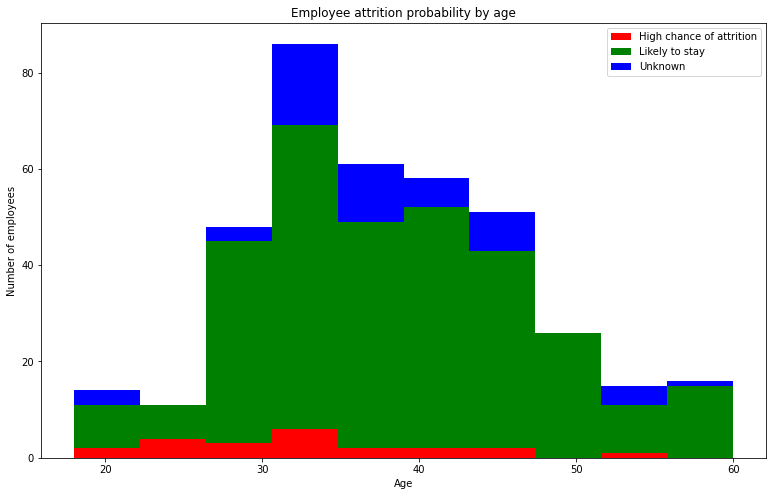

In [23]:
figure = plt.figure(figsize=(13,8))
predictions_frame= pd.DataFrame(predictions)
plt.hist([predictions_frame[predictions_frame['prediction']==2]['Age'],predictions_frame[predictions_frame['prediction']==1]['Age'],predictions_frame[predictions_frame['prediction']==0]['Age']], stacked=True, color = ['r','g','b'],
         label = ['High chance of attrition','Likely to stay','Unknown'])
plt.xlabel('Age')
plt.ylabel('Number of employees')
plt.legend()
plt.title("Employee attrition probability by age")

**2. By Monthly Income**

Text(0.5, 1.0, 'Employee attrition probability by Monthly Income')

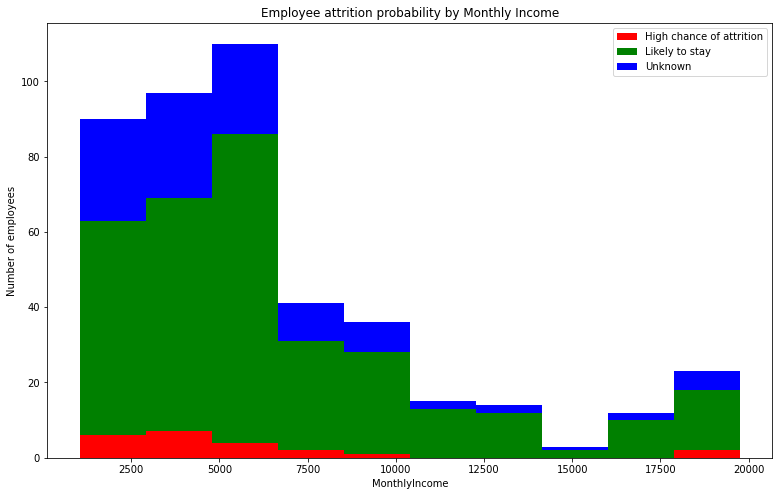

In [24]:
figure = plt.figure(figsize=(13,8))
predictions_frame= pd.DataFrame(predictions)
plt.hist([predictions_frame[predictions_frame['prediction']==2]['MonthlyIncome'],predictions_frame[predictions_frame['prediction']==1]['MonthlyIncome'],predictions_frame[predictions_frame['prediction']==0]['MonthlyIncome']], stacked=True, color = ['r','g','b'],
         label = ['High chance of attrition','Likely to stay','Unknown'])
plt.xlabel('MonthlyIncome')
plt.ylabel('Number of employees')
plt.legend()
plt.title("Employee attrition probability by Monthly Income")

**3. By Employee Satisfaction**

Employee Satisfaction = Job Satisfaction * Relationship Satisfaction

Text(0.5, 1.0, 'Employee attrition probability by Overall Satisfaction')

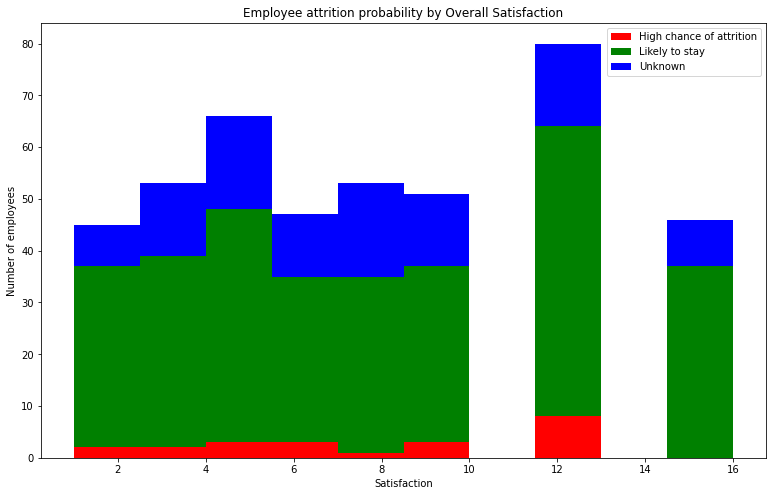

In [25]:
figure = plt.figure(figsize=(13,8))
predictions_frame= pd.DataFrame(predictions)
plt.hist([predictions_frame[predictions_frame['prediction']==2]['Satisfaction'],predictions_frame[predictions_frame['prediction']==1]['Satisfaction'],predictions_frame[predictions_frame['prediction']==0]['Satisfaction']], stacked=True, color = ['r','g','b'],
         label = ['High chance of attrition','Likely to stay','Unknown'])
plt.xlabel('Satisfaction')
plt.ylabel('Number of employees')
plt.legend()
plt.title("Employee attrition probability by Overall Satisfaction")

# Improving accuracy

In the model, we normalized the continuous integers and used one hot encoding for the categorical integers / strings.

This causes us to lose some form of relationship information between / within the categories.

Therefore, we will try to use [feature columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns) to allow for more flexibility in how we treat our columns.

In [26]:
%pip install -q sklearn

In [27]:
from tensorflow import feature_column
from sklearn.model_selection import train_test_split


We will reuse the dataframe

In [28]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('AttritionBinary')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

658 train examples
165 validation examples
206 test examples
Every feature: ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
A batch of ages: tf.Tensor([32 25 30 32 43], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


# Choosing the Feature columns

In [29]:
feature_columns = []

# numeric cols
for header in [    
      'DailyRate',
      'DistanceFromHome',
      'HourlyRate',
      'MonthlyIncome',
      'MonthlyRate',
      'NumCompaniesWorked',
      'PercentSalaryHike',
      'TotalWorkingYears',
      'TrainingTimesLastYear',
      'YearsAtCompany',
      'YearsInCurrentRole',
      'YearsSinceLastPromotion',
      'YearsWithCurrManager',
    ]:
  feature_columns.append(feature_column.numeric_column(header))


# bucketized cols
#We can bucketize the Age and Salary
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 20, 35, 45, 70])
feature_columns.append(age_buckets)


# indicator_columns
indicator_column_names = [
    'EducationField',
    'Gender',
    'MaritalStatus',
    'Over18',
    'OverTime', 
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StandardHours',
    'StockOptionLevel',
    'WorkLifeBalance',
    
]
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, dataframe[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

# embedding columns: BusinessTravel
businessTravel = feature_column.categorical_column_with_vocabulary_list(
      'BusinessTravel', dataframe.BusinessTravel.unique())
BusinessTravel_embedding = feature_column.embedding_column(businessTravel, dimension=8)
feature_columns.append(BusinessTravel_embedding)

# embedding columns: Department
department = feature_column.categorical_column_with_vocabulary_list(
      'Department', dataframe.BusinessTravel.unique())
department_embedding = feature_column.embedding_column(department, dimension=8)
feature_columns.append(department_embedding)

# embedding columns: JobRole
jobRole = feature_column.categorical_column_with_vocabulary_list(
      'JobRole', dataframe.BusinessTravel.unique())
JobRole_embedding = feature_column.embedding_column(jobRole, dimension=8)
feature_columns.append(JobRole_embedding)

# crossed columns
Department_Job_feature = feature_column.crossed_column([department, jobRole], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(Department_Job_feature))


In [30]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)


In [31]:
model_2 = tf.keras.Sequential([
  feature_layer,
  layers.Dropout(.2),
  layers.Dense(73, activation='relu'),
  layers.Dropout(.2),
  layers.Dense(73, activation='relu'),
  layers.Dense(1)
])

opt = keras.optimizers.Adam(learning_rate=0.001)

model_2.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_feature = model_2.fit(train_ds,
          validation_data=val_ds,
          epochs=70)

Epoch 1/70
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
130/132 [============================>.] - ETA: 0s - loss: 263.0870 - accuracy: 0.6152WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'BusinessTravel': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'DailyRate': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, 'Department': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'DistanceFromHome': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=int64>, 'Education': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=int64>, 'EducationField': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'EnvironmentSatisfaction': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int64>, 'Gender': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, '

In [32]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  72        
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  14235     
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  5402      
_________________________________________________________________
dense_2 (Dense)              multiple                  74        
Total params: 19,783
Trainable params: 19,783
Non-trainable params: 0
____________________________________________________

In [33]:
loss_2, accuracy_2 = model.evaluate(test_ds) 
print("Accuracy of first model with concatenated encoded input", accuracy_2)
print("----------------------------------------------------------------------")
loss, accuracy = model_2.evaluate(test_ds) 
print("Accuracy of second model with feature columns", accuracy)



42/42 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.9757
Accuracy of first model with concatenated encoded input 0.9757281541824341
----------------------------------------------------------------------
42/42 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.8447
Accuracy of second model with feature columns 0.844660222530365


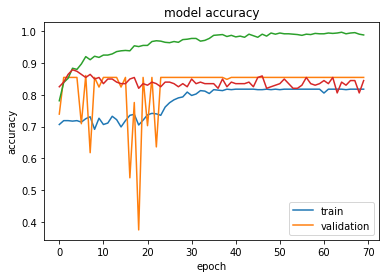

In [34]:
plot_train(history_feature)
plot_train(history)

# Conclusion

The First Model seemed to have a slightly better accuracy than the Second model, even though their validation accuracy was rather similar.

Could using feature columns differently improve the accuracy of the Second model? Maybe..

Thanks! This notebook can also be found here [royleekiat/Employee_attrition_predictor](https://github.com/royleekiat/Employee_attrition_predictor)